### Importing necessary libraries

In [1]:
import os
from io import BytesIO
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError

### Define functions for data exploration and preprocessing

In [2]:
def get_classes(dataset_dir):
    """
    Get the list of class names from the dataset directory.

    Args:
        dataset_dir (str): Path to the dataset directory.

    Returns:
        list: List of class names.
    """
    classes = os.listdir(dataset_dir)
    return classes


def analyze_dataset(dataset_dir, classes):
    """
    Analyze the dataset by printing the number of images per class and unique image shapes.

    Args:
        dataset_dir (str): Path to the dataset directory.
        classes (list): List of class names.
    """
    image_shapes = set()
    images_per_class = {}

    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)
        images_per_class[class_name] = len(image_files)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            try:
                image = Image.open(image_path)
                image_shapes.add(image.size + (len(image.getbands()),))
            except Exception as e:
                print(f"Error processing image: {image_path}, {e}")

    print("Number of Images per Class:")
    for class_name, count in images_per_class.items():
        print(f"{class_name}: {count}")

    print("\nUnique Image Shapes:")
    for shape in image_shapes:
        print(shape)

In [3]:
def preprocess_image(image):
    # Resize the image to the target size
    image = tf.image.resize(image, target_size)

    # If the image has an alpha channel, drop it
    if image.shape[2] == 4:
        image = image[:, :, :3]
        
    return image

def create_data_generator(data_dir, target_size, batch_size, validation_split=0.2, augmentation=False, **kwargs):
    """
    Create data generators for training and validation sets.

    Args:
        data_dir (str): Path to the dataset directory.
        target_size (tuple): Tuple specifying the target size of the input images.
        batch_size (int): Number of samples per batch.
        validation_split (float): Fraction of the data to use for validation.
        augmentation (bool): Whether to apply data augmentation.
        **kwargs: Additional arguments to pass to the ImageDataGenerator.

    Returns:
        tuple: (train_generator, validation_generator) - Data generators for training and validation sets.
    """
    if augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            shear_range=0.2,
            zoom_range=0.2,
            rotation_range=30,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=(0.85, 1.15),
            validation_split=validation_split,
            preprocessing_function=preprocess_image,
            **kwargs
        )
    else:
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            validation_split=validation_split,
            preprocessing_function=preprocess_image,
            **kwargs
        )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
    )

    return train_generator, validation_generator


def display_random_images_from_generator(data_generator, classes, num_images=8):
    images, labels = next(data_generator)
    class_indices = {v: k for k, v in classes.items()}  # Reverse the class indices dictionary
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16/1.5, 8/1.5))
    
    for i in range(num_images):
        row = i // 4
        col = i % 4
        image = images[i]
        label = labels[i]
        class_index = label.argmax()
        class_name = class_indices[class_index]
    
        axs[row, col].imshow(image)
        axs[row, col].axis('off')
        axs[row, col].set_title(class_name)
    
    plt.tight_layout()
    plt.show()

#### Image Preprocessing and Data Generators
- The preprocess_image function resizes images to a standard size and drops any alpha channel (transparency information) if it exists.

- The create_data_generator function creates an ImageDataGenerator which scales image pixel values, applies data augmentation (if enabled), and creates two sets of data: training data and validation data. This function allows you to load images in batches, which is necessary for training deep learning models when the entire dataset cannot fit into memory.

- The display_random_images_from_generator function displays a set of images from a generator. This is helpful for visualizing the data and transformations applied.

### Dataset exploration and preprocessing

In [4]:
dataset_dir = "dataset"
target_size = (256, 256)
classes = get_classes(dataset_dir)
print("Classes found in the dataset:", classes, "\n")
analyze_dataset(dataset_dir, classes)

Classes found in the dataset: ['cloudy', 'desert', 'green_area', 'water'] 

Number of Images per Class:
cloudy: 1500
desert: 1131
green_area: 1500
water: 1500

Unique Image Shapes:
(256, 256, 4)
(64, 64, 3)
(256, 256, 3)


In [5]:
train_generator, validation_generator = create_data_generator(dataset_dir, target_size=target_size,
                                                             batch_size=32, validation_split=0.2, augmentation=True)

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


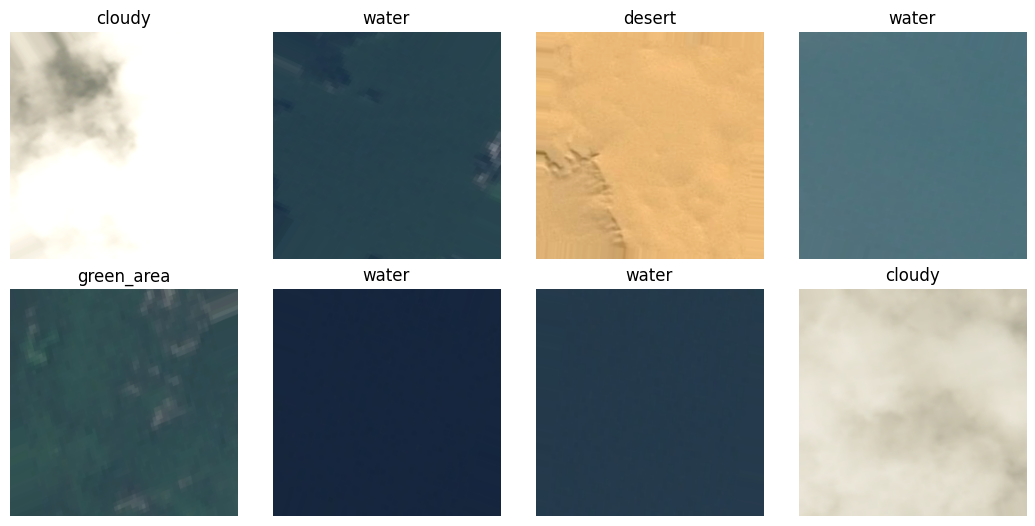

In [14]:
classes = train_generator.class_indices
display_random_images_from_generator(train_generator, classes, num_images=8)

### Building the model

In [7]:
def train_model(train_generator, validation_generator, target_size, num_classes, model_name,
                epochs=30, batch_size=32, patience=3, learning_rate=0.001):
    
    model = create_model(target_size + (3,), num_classes)
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], )
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_name + '.h5', save_best_only=True, save_weights_only=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the model on the validation set
    evaluation = model.evaluate(validation_generator)

    # Save the model
    model.save(model_name + '.h5')

    # Print message when early stopping is triggered
    if early_stopping.stopped_epoch > 0:
        print('Early stopping triggered at epoch', early_stopping.stopped_epoch + 1)

    return history, evaluation


def create_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.15))
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.30))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.50))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [8]:
# Train the model
history, evaluation = train_model(
    train_generator,
    validation_generator,
    target_size=target_size,
    num_classes=train_generator.num_classes,
    model_name='best_custom_model',
    epochs=20,
    batch_size=32,
    patience=3, 
    learning_rate=0.0001
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

#### Model Architecture
##### The model architecture is a simple Convolutional Neural Network (CNN). The layers are as follows:

- Conv2D: These are convolution layers that are designed to deal with image data. Each layer will apply filters to the previous layer's output and produce a convolved feature map.
- MaxPooling2D: These are pooling layers that will reduce the dimensionality of the feature maps, summarizing the presence of features in the previous layer's output.
- Dropout: These layers randomly set a fraction of input units to 0 at each update during training, which helps prevent overfitting.
- Flatten: This layer flattens the inputs, converting a multidimensional tensor into a one-dimensional tensor (i.e., a vector).
- Dense: These are fully connected layers where each neuron in a layer is connected to every neuron in the previous layer.
- The final Dense layer has 4 neurons, indicating that the model is designed to classify inputs into one of four classes.

### Saving the model for further use, plot and evaluate metrics

In [9]:
def plot_training_history(history):
    """
    Plot the training and validation loss, and training and validation accuracy.

    Args:
        history (tf.keras.callbacks.History): Training history.
    """
    num_epochs = len(history.history['loss'])

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle('Training History')

    axs[0].plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
    axs[0].plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#### Model Evaluation
- The evaluate_model function loads a trained model from a saved file and evaluates it using the validation generator. It calculates overall metrics (accuracy, precision, recall, F1-score) and class-specific metrics. These metrics provide a detailed view of model performance.

In [10]:
def evaluate_model(saved_model_path, validation_generator):
    # Load the saved model
    loaded_model = tf.keras.models.load_model(saved_model_path)

    # Evaluate the model on the test set
    test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)

    # Perform thorough evaluation
    y_true = validation_generator.classes
    y_pred = loaded_model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate overall metrics
    accuracy = metrics.accuracy_score(y_true, y_pred_classes)
    precision = metrics.precision_score(y_true, y_pred_classes, average='weighted')
    recall = metrics.recall_score(y_true, y_pred_classes, average='weighted')
    f1_score = metrics.f1_score(y_true, y_pred_classes, average='weighted')

    print('Overall Metrics:')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1_score)

    # Calculate metrics per class
    class_metrics = metrics.classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
    print('\nMetrics per Class:')
    print(class_metrics)

36/36 [==============================] - 30s 810ms/step - loss: 0.3546 - accuracy: 0.8597
Test Loss: 0.35464057326316833
Test Accuracy: 0.8596802949905396
36/36 [==============================] - 29s 794ms/step
Overall Metrics:
Accuracy: 0.8561278863232682
Precision: 0.875179706182935
Recall: 0.8561278863232682
F1-Score: 0.8531004531206136

Metrics per Class:
              precision    recall  f1-score   support

      cloudy       0.98      0.85      0.91       300
      desert       0.86      1.00      0.93       226
  green_area       0.74      0.96      0.83       300
       water       0.92      0.65      0.76       300

    accuracy                           0.86      1126
   macro avg       0.87      0.86      0.86      1126
weighted avg       0.88      0.86      0.85      1126



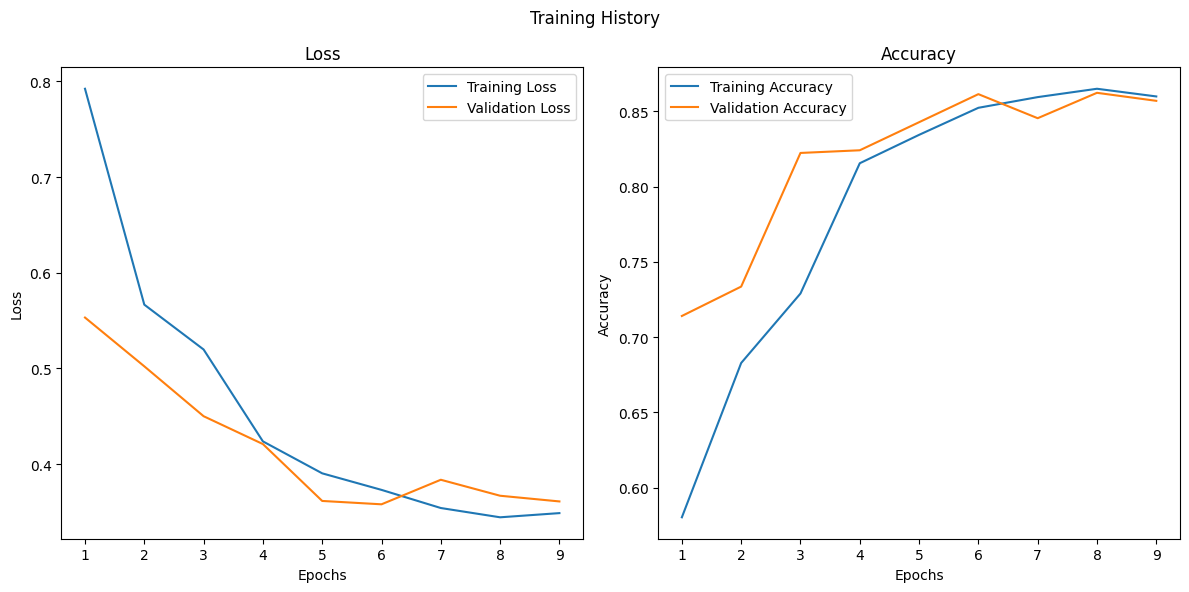

In [11]:
saved_model_path = 'best_custom_model.h5'

evaluate_model(saved_model_path, validation_generator)
plot_training_history(history)

### Build a function to predict random images from the internet

#### Predicting on New Data
- The predict_images_from_urls function predicts the class of new images provided via URLs. It fetches the images, preprocesses them, and feeds them into the model for prediction. The function also displays the images along with their predicted class. This function allows you to easily use the model to make predictions on new, unseen data.

In [12]:
def predict_images_from_urls(model, classes, image_urls, target_size):
    num_images = len(image_urls)
    num_rows = (num_images + 3) // 4

    fig, axs = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, 6))

    for i, image_url in enumerate(image_urls):
        row = i // 4
        col = i % 4

        # Download the image from the URL
        response = requests.get(image_url)

        if response.status_code == 200:
            try:
                image = Image.open(BytesIO(response.content))
                image = image.convert("RGB")  # Convert to RGB format

                # Resize the image
                image = image.resize(target_size)

                # Preprocess the image
                image_array = np.array(image) / 255.0
                image_array = np.expand_dims(image_array, axis=0)

                # Make the prediction
                prediction = model.predict(image_array)
                predicted_class_index = np.argmax(prediction)

                # Create a reverse dictionary of classes
                reverse_classes = {v: k for k, v in classes.items()}

                # Get the predicted class label
                predicted_class = reverse_classes[predicted_class_index]

                # Display the image and predicted class
                axs[row, col].imshow(image)
                axs[row, col].axis('off')
                axs[row, col].set_title(f"Predicted Class: {predicted_class}")
            except (UnidentifiedImageError, ImageDecompressionBombError) as e:
                print(f"Error processing image: {image_url}\n{e}")

    # Remove any empty subplots
    for i in range(num_images, num_rows * 4):
        row = i // 4
        col = i % 4
        fig.delaxes(axs[row, col])

    fig.tight_layout()
    plt.show()

1/1 [==============================] - 0s 43ms/step


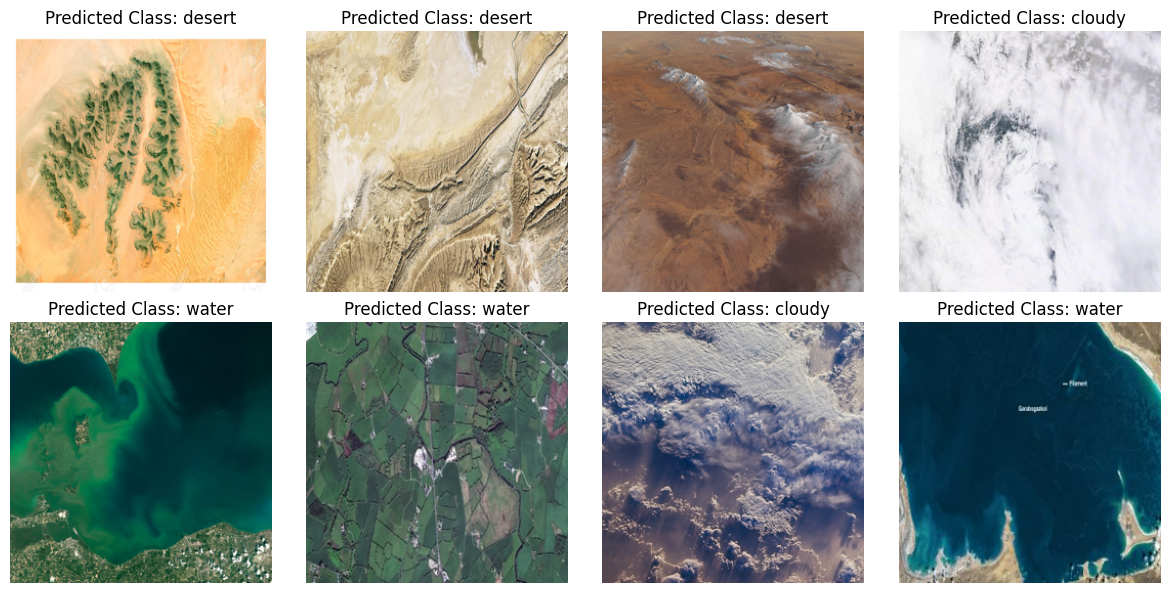

In [13]:
# Example list of image URLs
image_urls = [
    'https://previews.123rf.com/images/vampy1/vampy12007/vampy1200700021/151785736-satellite-view-of-namibia-desert-landscape-and-mountains-nature-and-aerial-view-global-warming.jpg',
    'https://thumbs.dreamstime.com/b/desert-land-satellite-photo-topography-aerial-top-view-earth-surface-as-abstract-background-nature-pattern-southern-sand-229623767.jpg',
    'https://cdn.mos.cms.futurecdn.net/Fry8CGJGgP6vgXBupGTqwT.jpg',
    'https://miro.medium.com/v2/resize:fit:1000/0*59yUF7X3jRrcrUnu.jpg',
    'https://media.rff.org/images/resized_erie_oli_2015209_lrg_40.2e16d0ba.fill-1270x1120.jpg',
    'https://img.rasset.ie/0014aa0a-500.jpg',
    'https://www.nasa.gov/images/content/624724main_pia15399-673.jpg',
    'https://cdn.mos.cms.futurecdn.net/aa3h9RKfsPcS8sPwyzSgu9-320-80.jpg',
]

# Load the saved custom model and classes
loaded_model = tf.keras.models.load_model(saved_model_path)

# Predict and display the images from the URLs
predict_images_from_urls(loaded_model, classes, image_urls, target_size)